In [1]:
# Load autoreload extension
%load_ext autoreload

# Set autoreload behavior
%autoreload 2
import os
import time
import argparse
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models.ProTACT import ProTACT
from models.Loss import LossFunctions
from configs.configs import Configs
from utils.read_data_pr import read_pos_vocab, read_word_vocab, read_prompts_we, read_essays_prompts, read_prompts_pos
from utils.general_utils import get_scaled_down_scores, pad_hierarchical_text_sequences, get_attribute_masks, load_word_embedding_dict, build_embedd_table
from evaluators.multitask_evaluator_all_attributes import Evaluator as AllAttEvaluator
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/joohwan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joohwan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# print("main started")
# parser = argparse.ArgumentParser(description="ProTACT model")
# parser.add_argument('--test_prompt_id', type=int,
#                     default=1, help='prompt id of test essay set')
# parser.add_argument('--seed', type=int, default=12, help='set random seed')
# parser.add_argument('--model_name', type=str,
#                     choices=['ProTACT'],
#                     help='name of model')
# parser.add_argument('--num_heads', type=int, default=2,
#                     help='set the number of heads in Multihead Attention')
# parser.add_argument('--features_path', type=str,
#                     default='data/hand_crafted_v3.csv')
test_prompt_id = 1
seed = 1
num_heads = 2
features_path = '../data/hand_crafted_v3.csv'

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(torch.cuda.is_available())
print("Test prompt id is {} of type {}".format(
    test_prompt_id, type(test_prompt_id)))
print("Seed: {}".format(seed))

configs = Configs()

data_path = configs.DATA_PATH
train_path = data_path + str(test_prompt_id) + '/train.pk'
dev_path = data_path + str(test_prompt_id) + '/dev.pk'
test_path = data_path + str(test_prompt_id) + '/test.pk'
pretrained_embedding = configs.PRETRAINED_EMBEDDING
embedding_path = configs.EMBEDDING_PATH
readability_path = configs.READABILITY_PATH
prompt_path = configs.PROMPT_PATH
vocab_size = configs.VOCAB_SIZE
epochs = configs.EPOCHS
batch_size = configs.BATCH_SIZE
print("Numhead : ", num_heads, " | Features : ",
      features_path, " | Pos_emb : ", configs.EMBEDDING_DIM)

read_configs = {
    'train_path': train_path,
    'dev_path': dev_path,
    'test_path': test_path,
    'features_path': features_path,
    'readability_path': readability_path,
    'vocab_size': vocab_size
}

False
Test prompt id is 1 of type <class 'int'>
Seed: 1
Numhead :  2  | Features :  ../data/hand_crafted_v3.csv  | Pos_emb :  50


In [3]:
# read POS for prompts
pos_vocab = read_pos_vocab(read_configs)
prompt_pos_data = read_prompts_pos(
    prompt_path, pos_vocab)  # for prompt POS embedding

# read words for prompts
word_vocab = read_word_vocab(read_configs)
# for prompt word embedding
prompt_data = read_prompts_we(prompt_path, word_vocab)

train_data, dev_data, test_data = read_essays_prompts(
    read_configs, prompt_data, prompt_pos_data, pos_vocab)

if pretrained_embedding:
    embedd_dict, embedd_dim, _ = load_word_embedding_dict(embedding_path)
    embedd_matrix = build_embedd_table(
        word_vocab, embedd_dict, embedd_dim, caseless=True)
    embed_table = embedd_matrix
else:
    embed_table = None

 prompt_pos size: 8
 prompt_words size: 8
 pos_x size: 9513
 readability_x size: 9513
 pos_x size: 1680
 readability_x size: 1680
 pos_x size: 1783
 readability_x size: 1783
Loading GloVe ...
OOV number =189, OOV ratio = 0.047262


In [4]:
max_sentlen = max(train_data['max_sentlen'],
                  dev_data['max_sentlen'], test_data['max_sentlen'])
max_sentnum = max(train_data['max_sentnum'],
                  dev_data['max_sentnum'], test_data['max_sentnum'])
prompt_max_sentlen = prompt_data['max_sentlen']
prompt_max_sentnum = prompt_data['max_sentnum']

print('max sent length: {}'.format(max_sentlen))
print('max sent num: {}'.format(max_sentnum))
print('max prompt sent length: {}'.format(prompt_max_sentlen))
print('max prompt sent num: {}'.format(prompt_max_sentnum))

train_data['y_scaled'] = get_scaled_down_scores(
    train_data['data_y'], train_data['prompt_ids'])
dev_data['y_scaled'] = get_scaled_down_scores(
    dev_data['data_y'], dev_data['prompt_ids'])
test_data['y_scaled'] = get_scaled_down_scores(
    test_data['data_y'], test_data['prompt_ids'])

X_train_pos = pad_hierarchical_text_sequences(
    train_data['pos_x'], max_sentnum, max_sentlen)
X_dev_pos = pad_hierarchical_text_sequences(
    dev_data['pos_x'], max_sentnum, max_sentlen)
X_test_pos = pad_hierarchical_text_sequences(
    test_data['pos_x'], max_sentnum, max_sentlen)

X_train_pos = X_train_pos.reshape(
    (X_train_pos.shape[0], X_train_pos.shape[1] * X_train_pos.shape[2]))
X_dev_pos = X_dev_pos.reshape(
    (X_dev_pos.shape[0], X_dev_pos.shape[1] * X_dev_pos.shape[2]))
X_test_pos = X_test_pos.reshape(
    (X_test_pos.shape[0], X_test_pos.shape[1] * X_test_pos.shape[2]))

X_train_prompt = pad_hierarchical_text_sequences(
    train_data['prompt_words'], max_sentnum, max_sentlen)
X_dev_prompt = pad_hierarchical_text_sequences(
    dev_data['prompt_words'], max_sentnum, max_sentlen)
X_test_prompt = pad_hierarchical_text_sequences(
    test_data['prompt_words'], max_sentnum, max_sentlen)

X_train_prompt = X_train_prompt.reshape(
    (X_train_prompt.shape[0], X_train_prompt.shape[1] * X_train_prompt.shape[2]))
X_dev_prompt = X_dev_prompt.reshape(
    (X_dev_prompt.shape[0], X_dev_prompt.shape[1] * X_dev_prompt.shape[2]))
X_test_prompt = X_test_prompt.reshape(
    (X_test_prompt.shape[0], X_test_prompt.shape[1] * X_test_prompt.shape[2]))

X_train_prompt_pos = pad_hierarchical_text_sequences(
    train_data['prompt_pos'], max_sentnum, max_sentlen)
X_dev_prompt_pos = pad_hierarchical_text_sequences(
    dev_data['prompt_pos'], max_sentnum, max_sentlen)
X_test_prompt_pos = pad_hierarchical_text_sequences(
    test_data['prompt_pos'], max_sentnum, max_sentlen)

X_train_prompt_pos = X_train_prompt_pos.reshape(
    (X_train_prompt_pos.shape[0], X_train_prompt_pos.shape[1] * X_train_prompt_pos.shape[2]))
X_dev_prompt_pos = X_dev_prompt_pos.reshape(
    (X_dev_prompt_pos.shape[0], X_dev_prompt_pos.shape[1] * X_dev_prompt_pos.shape[2]))
X_test_prompt_pos = X_test_prompt_pos.reshape(
    (X_test_prompt_pos.shape[0], X_test_prompt_pos.shape[1] * X_test_prompt_pos.shape[2]))

X_train_linguistic_features = np.array(train_data['features_x'])
X_dev_linguistic_features = np.array(dev_data['features_x'])
X_test_linguistic_features = np.array(test_data['features_x'])

X_train_readability = np.array(train_data['readability_x'])
X_dev_readability = np.array(dev_data['readability_x'])
X_test_readability = np.array(test_data['readability_x'])

Y_train = np.array(train_data['y_scaled'])
Y_dev = np.array(dev_data['y_scaled'])
Y_test = np.array(test_data['y_scaled'])

X_train_attribute_rel = get_attribute_masks(Y_train)
X_dev_attribute_rel = get_attribute_masks(Y_dev)
X_test_attribute_rel = get_attribute_masks(Y_test)

print('================================')
print('X_train_pos: ', X_train_pos.shape)
print('X_train_prompt_words: ', X_train_prompt.shape)
print('X_train_prompt_pos: ', X_train_prompt_pos.shape)
print('X_train_readability: ', X_train_readability.shape)
print('X_train_ling: ', X_train_linguistic_features.shape)
print('X_train_attribute_rel: ', X_train_attribute_rel.shape)
print('Y_train: ', Y_train.shape)

print('================================')
print('X_dev_pos: ', X_dev_pos.shape)
print('X_dev_prompt_words: ', X_dev_prompt.shape)
print('X_dev_prompt_pos: ', X_dev_prompt_pos.shape)
print('X_dev_readability: ', X_dev_readability.shape)
print('X_dev_ling: ', X_dev_linguistic_features.shape)
print('X_dev_attribute_rel: ', X_dev_attribute_rel.shape)
print('Y_dev: ', Y_dev.shape)

print('================================')
print('X_test_pos: ', X_test_pos.shape)
print('X_test_prompt_words: ', X_test_prompt.shape)
print('X_test_prompt_pos: ', X_test_prompt_pos.shape)
print('X_test_readability: ', X_test_readability.shape)
print('X_test_ling: ', X_test_linguistic_features.shape)
print('X_test_attribute_rel: ', X_test_attribute_rel.shape)
print('Y_test: ', Y_test.shape)
print('================================')

max sent length: 50
max sent num: 97
max prompt sent length: 18
max prompt sent num: 8
X_train_pos:  (9513, 4850)
X_train_prompt_words:  (9513, 4850)
X_train_prompt_pos:  (9513, 4850)
X_train_readability:  (9513, 35)
X_train_ling:  (9513, 51)
X_train_attribute_rel:  (9513, 9)
Y_train:  (9513, 9)
X_dev_pos:  (1680, 4850)
X_dev_prompt_words:  (1680, 4850)
X_dev_prompt_pos:  (1680, 4850)
X_dev_readability:  (1680, 35)
X_dev_ling:  (1680, 51)
X_dev_attribute_rel:  (1680, 9)
Y_dev:  (1680, 9)
X_test_pos:  (1783, 4850)
X_test_prompt_words:  (1783, 4850)
X_test_prompt_pos:  (1783, 4850)
X_test_readability:  (1783, 35)
X_test_ling:  (1783, 51)
X_test_attribute_rel:  (1783, 9)
Y_test:  (1783, 9)


In [5]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# to torch tensor
train_dataset = TensorDataset(
    torch.from_numpy(X_train_pos).to(device),
    torch.from_numpy(X_train_prompt).to(device),
    torch.from_numpy(X_train_prompt_pos).to(device),
    torch.from_numpy(X_train_linguistic_features).to(device),
    torch.from_numpy(X_train_readability).to(device),
    torch.from_numpy(Y_train).to(device)
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

dev_dataset = TensorDataset(
    torch.from_numpy(X_dev_pos).to(device),
    torch.from_numpy(X_dev_prompt).to(device),
    torch.from_numpy(X_dev_prompt_pos).to(device),
    torch.from_numpy(X_dev_linguistic_features).to(device),
    torch.from_numpy(X_dev_readability).to(device),
    torch.from_numpy(Y_dev).to(device),
)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

dev_features_list = [
    torch.from_numpy(X_dev_pos).to(device),
    torch.from_numpy(X_dev_prompt).to(device),
    torch.from_numpy(X_dev_prompt_pos).to(device),
    torch.from_numpy(X_dev_linguistic_features).to(device),
    torch.from_numpy(X_dev_readability).to(device)
]
test_features_list = [
    torch.from_numpy(X_test_pos).to(device),
    torch.from_numpy(X_test_prompt).to(device),
    torch.from_numpy(X_test_prompt_pos).to(device),
    torch.from_numpy(X_test_linguistic_features).to(device),
    torch.from_numpy(X_test_readability).to(device)
]

In [6]:
# build model
model = ProTACT(
    len(pos_vocab), len(word_vocab), max_sentnum, max_sentlen,
    X_train_readability.shape[1], X_train_linguistic_features.shape[1],
    configs, Y_train.shape[1], num_heads, embed_table
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# loss function and optimizer
criterion = LossFunctions(alpha=0.7)
optimizer = torch.optim.RMSprop(
    model.parameters(), lr=configs.LEARNING_RATE)

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

self.essay_pos_attention_list ModuleList(
  (0-96): 97 x Attention()
)
Layer: essay_pos_embedding.weight | Size: torch.Size([36, 50])
Layer: essay_pos_conv.weight | Size: torch.Size([100, 50, 5])
Layer: essay_pos_conv.bias | Size: torch.Size([100])
Layer: essay_pos_attention_list.0.att_V | Size: torch.Size([100])
Layer: essay_pos_attention_list.0.att_W | Size: torch.Size([100, 100])
Layer: essay_pos_attention_list.1.att_V | Size: torch.Size([100])
Layer: essay_pos_attention_list.1.att_W | Size: torch.Size([100, 100])
Layer: essay_pos_attention_list.2.att_V | Size: torch.Size([100])
Layer: essay_pos_attention_list.2.att_W | Size: torch.Size([100, 100])
Layer: essay_pos_attention_list.3.att_V | Size: torch.Size([100])
Layer: essay_pos_attention_list.3.att_W | Size: torch.Size([100, 100])
Layer: essay_pos_attention_list.4.att_V | Size: torch.Size([100])
Layer: essay_pos_attention_list.4.att_W | Size: torch.Size([100, 100])
Layer: essay_pos_attention_list.5.att_V | Size: torch.Size([100])


In [7]:
evaluator = AllAttEvaluator(
    test_prompt_id, dev_data['prompt_ids'], test_data['prompt_ids'],
    [x.numpy() for x in dev_features_list],
    [x.numpy() for x in test_features_list], Y_dev, Y_test, seed
)

evaluator.evaluate(model, -1, print_info=True)

/Users/joohwan/miniforge3/envs/jup/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/joohwan/miniforge3/envs/jup/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Save best model to checkpoint_best1_1.pth
CURRENT EPOCH: -1
[DEV] AVG QWK: -0.0
[DEV] score QWK: 0.042
[DEV] content QWK: -0.009
[DEV] organization QWK: 0.0
[DEV] word_choice QWK: -0.022
[DEV] sentence_fluency QWK: 0.024
[DEV] conventions QWK: -0.039
[DEV] prompt_adherence QWK: 0.036
[DEV] language QWK: -0.004
[DEV] narrativity QWK: -0.032
------------------------
[TEST] AVG QWK: -0.024
[TEST] score QWK: 0.001
[TEST] content QWK: -0.094
[TEST] organization QWK: 0.063
[TEST] word_choice QWK: -0.125
[TEST] sentence_fluency QWK: 0.0
[TEST] conventions QWK: 0.012
------------------------
[BEST TEST] AVG QWK: -0.024, {epoch}: -1
[BEST TEST] score QWK: 0.001
[BEST TEST] content QWK: -0.094
[BEST TEST] organization QWK: 0.063
[BEST TEST] word_choice QWK: -0.125
[BEST TEST] sentence_fluency QWK: 0.0
[BEST TEST] conventions QWK: 0.012
--------------------------------------------------------------------------------------------------------------------------


Epoch 1/50


Validating: 100%|█████████████████████████████████████████████████████████████| 168/168 [01:56<00:00,  1.44it/s, val_loss=0.00188]


Training one epoch in 4234.959 s


/Users/joohwan/miniforge3/envs/jup/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/joohwan/miniforge3/envs/jup/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Save best model to checkpoint_best1_1.pth
CURRENT EPOCH: 1
[DEV] AVG QWK: 0.042
[DEV] score QWK: 0.0
[DEV] content QWK: 0.031
[DEV] organization QWK: 0.116
[DEV] word_choice QWK: 0.041
[DEV] sentence_fluency QWK: 0.097
[DEV] conventions QWK: 0.049
[DEV] prompt_adherence QWK: 0.008
[DEV] language QWK: 0.028
[DEV] narrativity QWK: 0.012
------------------------
[TEST] AVG QWK: 0.097
[TEST] score QWK: 0.0
[TEST] content QWK: 0.009
[TEST] organization QWK: 0.084
[TEST] word_choice QWK: 0.191
[TEST] sentence_fluency QWK: 0.261
[TEST] conventions QWK: 0.037
------------------------
[BEST TEST] AVG QWK: 0.097, {epoch}: 1
[BEST TEST] score QWK: 0.0
[BEST TEST] content QWK: 0.009
[BEST TEST] organization QWK: 0.084
[BEST TEST] word_choice QWK: 0.191
[BEST TEST] sentence_fluency QWK: 0.261
[BEST TEST] conventions QWK: 0.037
--------------------------------------------------------------------------------------------------------------------------
Train Loss: 0.0057 || Val Loss: 0.0019
[BEST TEST] 

FileNotFoundError: [Errno 2] No such file or directory: 'images/protact/test_prompt_1_seed_1_loss.png'

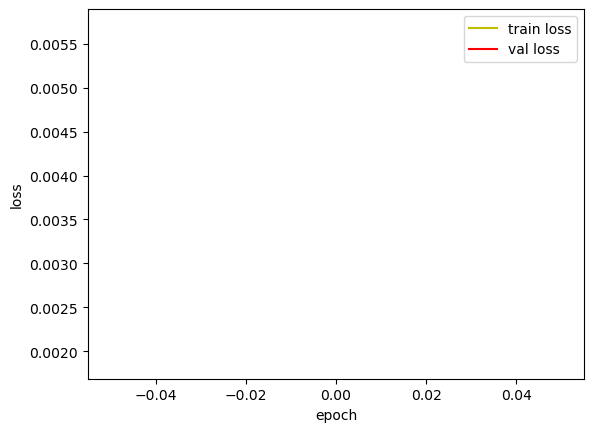

In [9]:
import time
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

class CustomHistory:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def update(self, train_loss, val_loss):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)

custom_hist = CustomHistory()

for epoch in range(1):  # e.g., epochs = 50
    print(f'Epoch {epoch + 1}/{epochs}')
    start_time = time.time()

    # Training phase
    model.train()
    train_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs} - Training", leave=True) as pbar:
        for batch_data in train_loader:
            optimizer.zero_grad()
            batch_data = [x.to(device) for x in batch_data]
            inputs, targets = batch_data[:-1], batch_data[-1]
            outputs = model(*inputs)
            loss = criterion.loss_function(targets.float(), outputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_data[0].size(0)
            pbar.set_postfix({'train_loss': train_loss / len(train_loader.dataset)})
            pbar.update(1)
    train_loss /= len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(total=len(dev_loader), desc='Validating', leave=True) as pbar:
            for batch_data in dev_loader:
                batch_data = [x.to(device) for x in batch_data]
                inputs, targets = batch_data[:-1], batch_data[-1]
                outputs = model(*inputs)
                loss = criterion.loss_function(targets.float(), outputs)
                val_loss += loss.item() * batch_data[0].size(0)
                pbar.set_postfix({'val_loss': val_loss / len(dev_loader.dataset)})
                pbar.update(1)
    val_loss /= len(dev_loader.dataset)

    # Update custom history
    custom_hist.update(train_loss, val_loss)

    # Evaluate the model
    tt_time = time.time() - start_time
    print(f"Training one epoch in {tt_time:.3f} s")
    evaluator.evaluate(model, epoch + 1)
    print(f"Train Loss: {train_loss:.4f} || Val Loss: {val_loss:.4f}")

# Print final evaluation info
evaluator.print_final_info()

# Show the loss as the graph
fig, loss_graph = plt.subplots()
loss_graph.plot(custom_hist.train_loss, 'y', label='train loss')
loss_graph.plot(custom_hist.val_loss, 'r', label='val loss')
loss_graph.set_xlabel('epoch')
loss_graph.set_ylabel('loss')
plt.legend()
plt.savefig(f'images/protact/test_prompt_{test_prompt_id}_seed_{seed}_loss.png')
plt.show()

In [8]:

class CustomHistory:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def update(self, train_loss, val_loss):
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)
        
        
custom_hist = CustomHistory()

for epoch in range(epochs): # 50
    print(f'Epoch {epoch + 1}/{epochs}')
    start_time = time.time()

    # train
    model.train()
    train_loss = 0.0
    for batch_data in train_loader:
        optimizer.zero_grad()
        batch_data = [x.to(device) for x in batch_data]
        inputs, targets = batch_data[:-1], batch_data[-1]
        outputs = model(*inputs)
        loss = criterion.loss_function(targets.float(),outputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_data[0].size(0)
    train_loss /= len(train_loader.dataset)

    # validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_data in dev_loader:
            batch_data = [x.to(device) for x in batch_data]
            inputs, targets = batch_data[:-1], batch_data[-1]
            outputs = model(*inputs)
            #loss = criterion(outputs, targets)
            loss = criterion.loss_function(targets.float(), outputs)
            val_loss += loss.item() * batch_data[0].size(0)
        val_loss /= len(dev_loader.dataset)

    custom_hist.update(train_loss, val_loss)

    # evaluate
    tt_time = time.time() - start_time
    print(f"Training one epoch in {tt_time:.3f} s")
    evaluator.evaluate(model, epoch + 1)
    print(f"Train Loss: {train_loss:.4f} || Val Loss: {val_loss:.4f}")

evaluator.print_final_info()

'''# show the loss as the graph
fig, loss_graph = plt.subplots()
loss_graph.plot(custom_hist.train_loss,'y',label='train loss')
loss_graph.plot(custom_hist.val_loss,'r',label='val loss')
loss_graph.set_xlabel('epoch')
loss_graph.set_ylabel('loss')
plt.savefig(str('images/protact/test_prompt_'+ str(test_prompt_id) + '_seed_' + str(seed) + '_loss.png'))'''

Epoch 1/50
pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
y: torch.Size([10, 9])
trait num:  9
pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
y: torch.Size([10, 9])
trait num:  9
pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10,

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
y: torch.Size([10, 9])
trait num:  9
pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

pos_drop_x:  torch.Size([10, 4850, 50])
pos_resh_W torch.Size([10, 97, 50, 50])
pos_zcnn torch.Size([10, 97, 46, 100])
pos_avg_zcnn torch.Size([10, 97, 100])
prompt_zcnn torch.Size([10, 97, 46, 100])
prompt_avg_zcnn torch.Size([10, 97, 100])
prompt_MA_lstm shape:  torch.Size([10, 97, 100])
linguistic_input:  torch.Size([10, 51])
readability_input:  torch.Size([10, 35])
es_pr_feat_concat:  9 ,  torch.Size([10, 186])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1, 186])
attention_concat: torch.Size([10, 1, 372])
non_target_rep: torch.Size([10, 8, 186])
target_rep: torch.Size([10, 1, 186])
att_output: torch.Size([10, 1

KeyboardInterrupt: 

In [ ]:
Y_train.shape